In [17]:
PATH_TO_DATASET = "../../../datasets/Massachusetts_roads/tiff/"

import os
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

## Example Usage

### Option 1: Process entire dataset and save to disk
```python
# This will create 25 non-overlapping 256x256 patches per 1500x1500 image
crop_dataset(
    PATH_TO_DATASET, 
    train_subdir="train",
    labels_subdir="train_labels",
    patch_size=256,
    overlap=False,
    output_dir="../../datasets/Massachusetts_roads/patches_256/"
)
```

### Option 2: Load patches into memory
```python
# Get all patches as numpy arrays
result = crop_dataset(
    PATH_TO_DATASET, 
    patch_size=256,
    overlap=False
)
train_patches = result['train_patches']  # List of numpy arrays
label_patches = result['label_patches']  # List of numpy arrays
metadata = result['metadata']  # Information about each patch
```

### Option 3: Get random crops for quick testing
```python
# Extract 100 random 256x256 crops
train_crops, label_crops = get_random_crops(
    PATH_TO_DATASET,
    patch_size=256,
    num_crops=100
)
# Returns numpy arrays of shape (100, 256, 256, channels)
```

### Option 4: Get n random crops per image
```python
# Extract 5 random crops from each image in the dataset (all images)
result = get_n_random_crops_per_image(
    PATH_TO_DATASET,
    patch_size=256,
    n_crops_per_image=5,
    num_images=-1  # -1 means process all images (default)
)

# Extract 5 random crops per image, but only process first 10 images
result = get_n_random_crops_per_image(
    PATH_TO_DATASET,
    patch_size=256,
    n_crops_per_image=5,
    num_images=10  # Process only first 10 images
)

train_crops = result['train_crops']
label_crops = result['label_crops']
metadata = result['metadata']  # Includes coordinates for visualization
```

### Option 5: Visualize crop locations
```python
# First get crops with metadata
result = get_n_random_crops_per_image(PATH_TO_DATASET, n_crops_per_image=5, num_images=3)

# Visualize where crops were taken from (first 3 images)
visualize_crop_locations(
    PATH_TO_DATASET,
    metadata=result['metadata'],
    patch_size=256,
    max_images=3
)

# Or visualize a specific image
visualize_crop_locations(
    PATH_TO_DATASET,
    metadata=result['metadata'],
    image_name='some_image.tif',
    patch_size=256
)
```

In [14]:
def crop_image_into_patches(image, patch_size=256, overlap=False):
    """
    Crop a single image into non-overlapping patches.
    
    Args:
        image: PIL Image or numpy array
        patch_size: Size of square patches (default: 256)
        overlap: If False, patches don't overlap. If True, sliding window with stride=patch_size//2
    
    Returns:
        List of patches as numpy arrays
        List of (x, y) coordinates for each patch
    """
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image
    
    h, w = img_array.shape[:2]
    patches = []
    coordinates = []
    
    stride = patch_size if not overlap else patch_size // 2
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img_array[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            coordinates.append((x, y))
    
    return patches, coordinates


def crop_dataset(dataset_path, train_subdir="train", labels_subdir="train_labels", 
                 patch_size=256, overlap=False, output_dir=None):
    """
    Crop all images in train and train_labels directories into patches.
    
    Args:
        dataset_path: Path to dataset directory
        train_subdir: Name of training images subdirectory
        labels_subdir: Name of labels subdirectory
        patch_size: Size of square patches
        overlap: Whether patches should overlap
        output_dir: Optional output directory. If None, returns patches in memory
    
    Returns:
        Dictionary with 'train_patches', 'label_patches', and 'metadata'
    """
    train_dir = Path(dataset_path) / train_subdir
    labels_dir = Path(dataset_path) / labels_subdir
    
    if not train_dir.exists() or not labels_dir.exists():
        raise ValueError(f"Directories not found: {train_dir} or {labels_dir}")
    
    train_files = sorted(list(train_dir.glob("*.tif*")) + list(train_dir.glob("*.png")) + list(train_dir.glob("*.jpg")))
    
    all_train_patches = []
    all_label_patches = []
    metadata = []
    
    for train_file in train_files:
        # Find corresponding label file
        label_file = labels_dir / train_file.name
        
        if not label_file.exists():
            print(f"Warning: No label found for {train_file.name}, skipping...")
            continue
        
        # Load images
        train_img = Image.open(train_file)
        label_img = Image.open(label_file)
        
        # Crop into patches (using same coordinates for both)
        train_patches, coords = crop_image_into_patches(train_img, patch_size, overlap)
        label_patches, _ = crop_image_into_patches(label_img, patch_size, overlap)
        
        # Save or store patches
        if output_dir:
            output_path = Path(output_dir)
            output_train = output_path / train_subdir
            output_labels = output_path / labels_subdir
            output_train.mkdir(parents=True, exist_ok=True)
            output_labels.mkdir(parents=True, exist_ok=True)
            
            base_name = train_file.stem
            for i, (train_patch, label_patch, coord) in enumerate(zip(train_patches, label_patches, coords)):
                patch_name = f"{base_name}_patch_{i:03d}_x{coord[0]}_y{coord[1]}.png"
                Image.fromarray(train_patch).save(output_train / patch_name)
                Image.fromarray(label_patch).save(output_labels / patch_name)
        else:
            all_train_patches.extend(train_patches)
            all_label_patches.extend(label_patches)
            
        # Store metadata
        for i, coord in enumerate(coords):
            metadata.append({
                'source_file': train_file.name,
                'patch_index': i,
                'x': coord[0],
                'y': coord[1]
            })
        
        print(f"Processed {train_file.name}: {len(train_patches)} patches")
    
    return {
        'train_patches': all_train_patches,
        'label_patches': all_label_patches,
        'metadata': metadata
    }


def get_random_crops(dataset_path, train_subdir="train", labels_subdir="train_labels",
                     patch_size=256, num_crops=100):
    """
    Extract random crops from the dataset (useful for quick sampling).
    
    Args:
        dataset_path: Path to dataset directory
        train_subdir: Name of training images subdirectory
        labels_subdir: Name of labels subdirectory
        patch_size: Size of square patches
        num_crops: Number of random crops to extract
    
    Returns:
        train_crops, label_crops (as numpy arrays)
    """
    train_dir = Path(dataset_path) / train_subdir
    labels_dir = Path(dataset_path) / labels_subdir
    
    train_files = sorted(list(train_dir.glob("*.tif*")) + list(train_dir.glob("*.png")) + list(train_dir.glob("*.jpg")))
    
    train_crops = []
    label_crops = []
    
    for _ in range(num_crops):
        # Pick random file
        train_file = np.random.choice(train_files)
        label_file = labels_dir / train_file.name
        
        # Load images
        train_img = np.array(Image.open(train_file))
        label_img = np.array(Image.open(label_file))
        
        h, w = train_img.shape[:2]
        
        # Random crop position
        max_y = h - patch_size
        max_x = w - patch_size
        x = np.random.randint(0, max_x + 1)
        y = np.random.randint(0, max_y + 1)
        
        # Extract crop
        train_crop = train_img[y:y+patch_size, x:x+patch_size]
        label_crop = label_img[y:y+patch_size, x:x+patch_size]
        
        train_crops.append(train_crop)
        label_crops.append(label_crop)
    
    return np.array(train_crops), np.array(label_crops)

In [15]:
def get_n_random_crops_per_image(dataset_path, train_subdir="train", labels_subdir="train_labels",
                                  patch_size=256, n_crops_per_image=5, num_images=-1):
    """
    Extract n random crops from each image in the dataset.
    
    Args:
        dataset_path: Path to dataset directory
        train_subdir: Name of training images subdirectory
        labels_subdir: Name of labels subdirectory
        patch_size: Size of square patches
        n_crops_per_image: Number of random crops to extract per image
        num_images: Number of images to process. If -1 (default), processes all images in the dataset.
                    If positive, processes only the first num_images images.
    
    Returns:
        Dictionary with:
            'train_crops': List of train crop arrays
            'label_crops': List of label crop arrays
            'metadata': List of dicts with source_file, crop_index, x, y coordinates
    """
    train_dir = Path(dataset_path) / train_subdir
    labels_dir = Path(dataset_path) / labels_subdir
    
    if not train_dir.exists() or not labels_dir.exists():
        raise ValueError(f"Directories not found: {train_dir} or {labels_dir}")
    
    train_files = sorted(list(train_dir.glob("*.tif*")) + list(train_dir.glob("*.png")) + list(train_dir.glob("*.jpg")))
    
    # Limit number of images if specified
    if num_images > 0:
        train_files = train_files[:num_images]
    
    all_train_crops = []
    all_label_crops = []
    metadata = []
    
    for train_file in train_files:
        label_file = labels_dir / train_file.name
        
        if not label_file.exists():
            print(f"Warning: No label found for {train_file.name}, skipping...")
            continue
        
        # Load images
        train_img = np.array(Image.open(train_file))
        label_img = np.array(Image.open(label_file))
        
        h, w = train_img.shape[:2]
        max_y = h - patch_size
        max_x = w - patch_size
        
        # Generate n random crops for this image
        for crop_idx in range(n_crops_per_image):
            x = np.random.randint(0, max_x + 1)
            y = np.random.randint(0, max_y + 1)
            
            # Extract matching crops
            train_crop = train_img[y:y+patch_size, x:x+patch_size]
            label_crop = label_img[y:y+patch_size, x:x+patch_size]
            
            all_train_crops.append(train_crop)
            all_label_crops.append(label_crop)
            
            metadata.append({
                'source_file': train_file.name,
                'crop_index': crop_idx,
                'x': x,
                'y': y
            })
        
        print(f"Extracted {n_crops_per_image} random crops from {train_file.name}")
    
    return {
        'train_crops': all_train_crops,
        'label_crops': all_label_crops,
        'metadata': metadata
    }


def visualize_crop_locations(dataset_path, train_subdir="train", labels_subdir="train_labels",
                             metadata=None, image_name=None, patch_size=256,
                             max_images=5, figsize=(15, 10)):
    """
    Visualize where crops were taken from the original images by drawing bounding boxes.
    
    Args:
        dataset_path: Path to dataset directory
        train_subdir: Name of training images subdirectory
        labels_subdir: Name of labels subdirectory
        metadata: List of metadata dicts (from get_n_random_crops_per_image or crop_dataset)
        image_name: Optional - visualize only this specific image
        patch_size: Size of the crop patches
        max_images: Maximum number of images to visualize (if image_name not specified)
        figsize: Figure size for the plot
    """
    if metadata is None:
        raise ValueError("metadata parameter is required")
    
    train_dir = Path(dataset_path) / train_subdir
    labels_dir = Path(dataset_path) / labels_subdir
    
    # Group metadata by source file
    crops_by_file = {}
    for item in metadata:
        source = item['source_file']
        if source not in crops_by_file:
            crops_by_file[source] = []
        crops_by_file[source].append(item)
    
    # Filter to specific image if requested
    if image_name:
        if image_name not in crops_by_file:
            raise ValueError(f"Image {image_name} not found in metadata")
        crops_by_file = {image_name: crops_by_file[image_name]}
    else:
        # Limit to max_images
        crops_by_file = dict(list(crops_by_file.items())[:max_images])
    
    num_images = len(crops_by_file)
    fig, axes = plt.subplots(num_images, 2, figsize=figsize)
    
    # Handle single image case
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (filename, crops) in enumerate(crops_by_file.items()):
        # Load the original images
        train_img = np.array(Image.open(train_dir / filename))
        label_img = np.array(Image.open(labels_dir / filename))
        
        # Plot train image with bounding boxes
        axes[idx, 0].imshow(train_img)
        axes[idx, 0].set_title(f"Train: {filename}\n({len(crops)} crops)", fontsize=10)
        axes[idx, 0].axis('off')
        
        # Plot label image with bounding boxes
        axes[idx, 1].imshow(label_img)
        axes[idx, 1].set_title(f"Label: {filename}\n({len(crops)} crops)", fontsize=10)
        axes[idx, 1].axis('off')
        
        # Draw bounding boxes for each crop
        colors = plt.cm.rainbow(np.linspace(0, 1, len(crops)))
        
        for crop_idx, crop_info in enumerate(crops):
            x, y = crop_info['x'], crop_info['y']
            color = colors[crop_idx]
            
            # Draw rectangle on train image
            rect_train = mpatches.Rectangle(
                (x, y), patch_size, patch_size,
                linewidth=2, edgecolor=color, facecolor='none', alpha=0.8
            )
            axes[idx, 0].add_patch(rect_train)

            
            # Draw rectangle on label image
            rect_label = mpatches.Rectangle(
                (x, y), patch_size, patch_size,
                linewidth=2, edgecolor=color, facecolor='none', alpha=0.8
            )
            axes[idx, 1].add_patch(rect_label)
            
    plt.tight_layout()
    plt.show()
    
    return fig

## Get random crops

In [18]:
train_crops, label_crops = get_random_crops(
    PATH_TO_DATASET,
    patch_size=256,
    num_crops=100
)

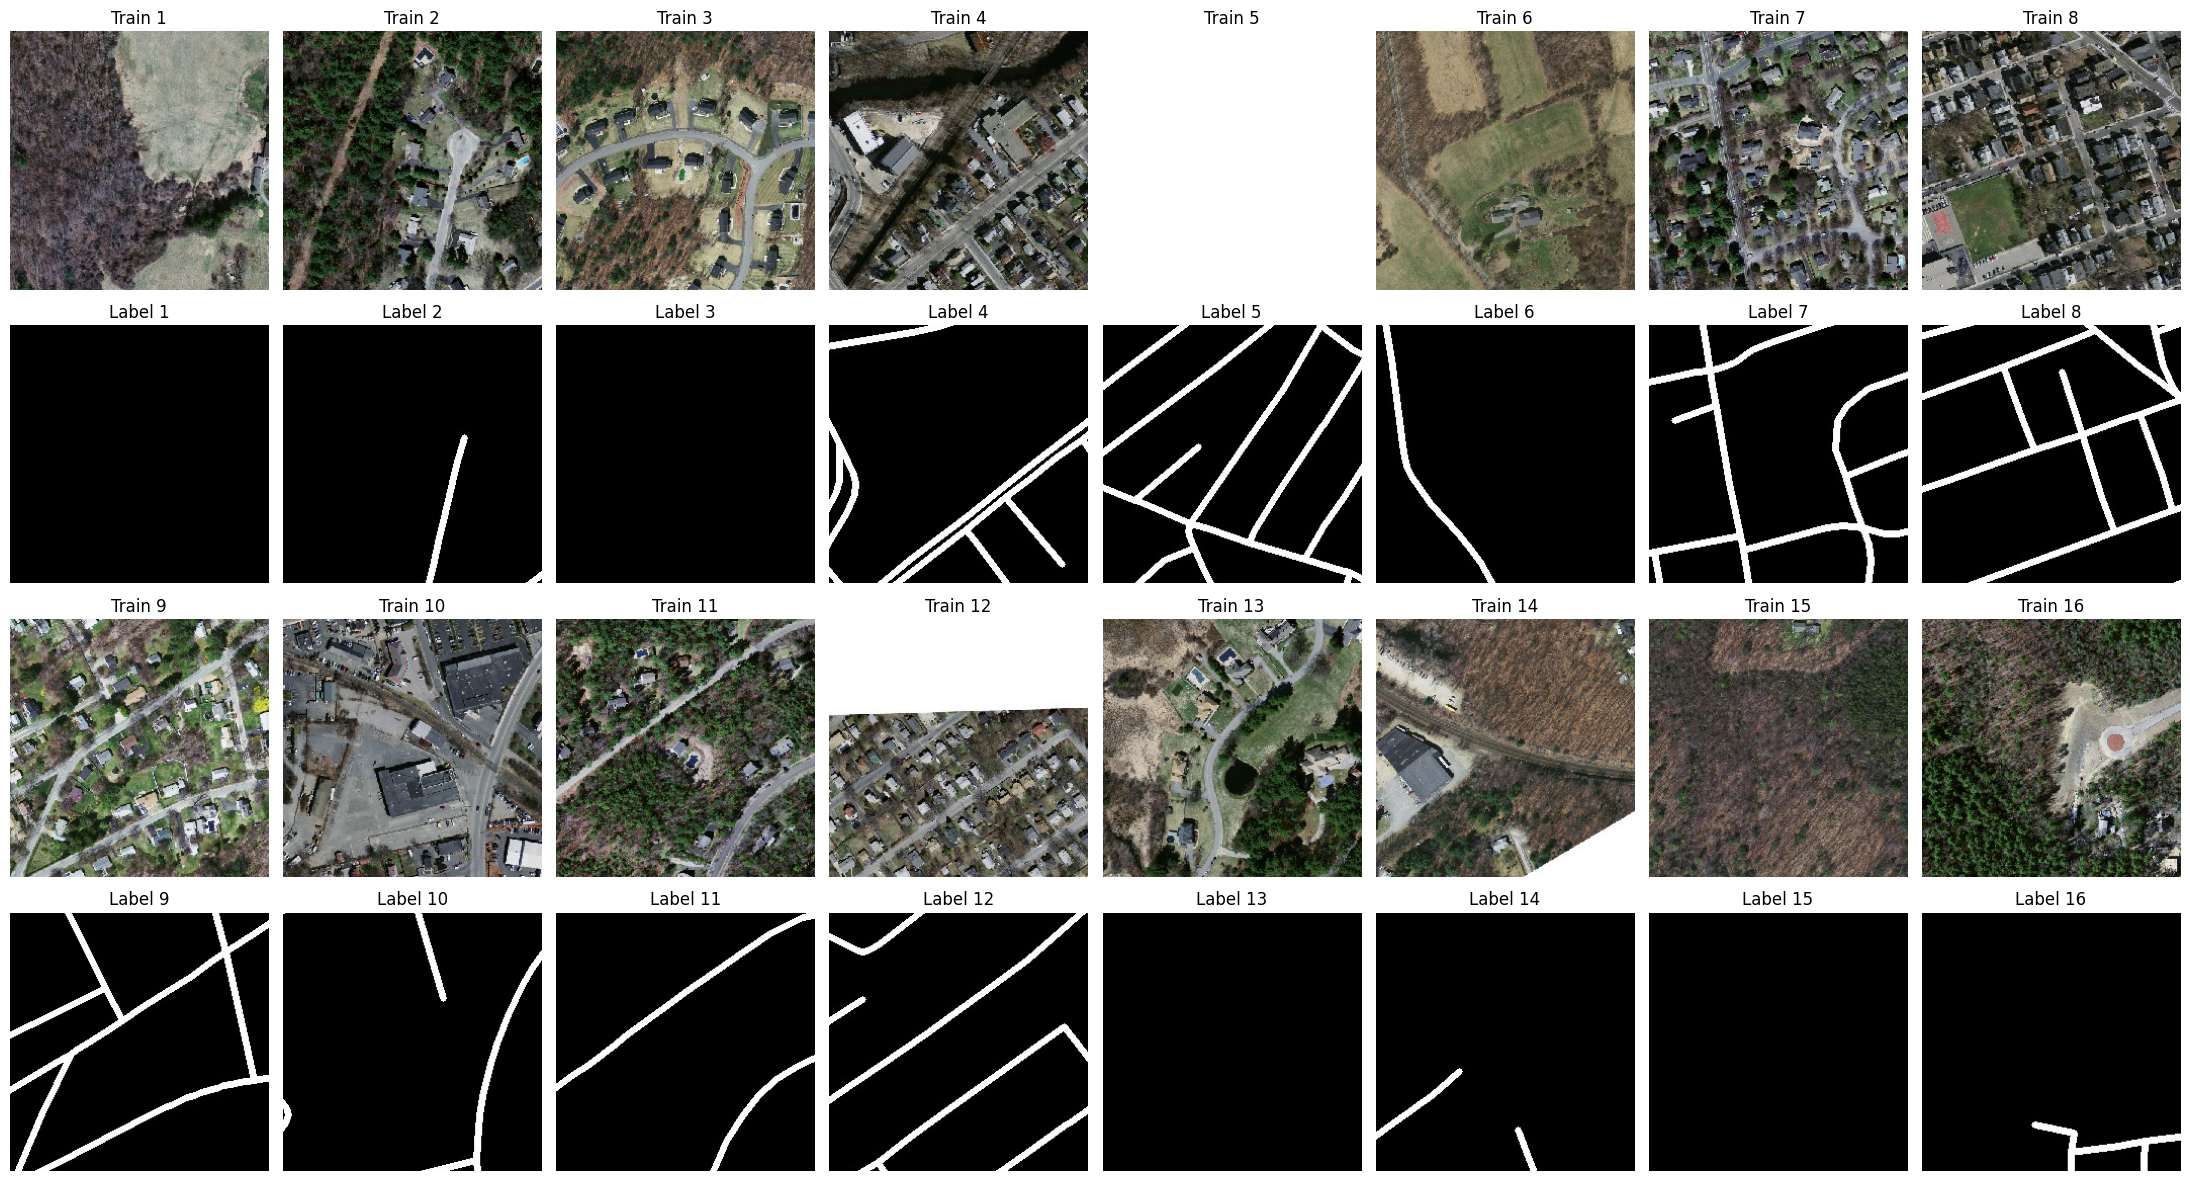

In [19]:
images_per_row = 8
num_sets = 2             # two sets of (train + label)
num_rows = num_sets * 2  # 4 total rows

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(22, 12))
axes = axes.reshape(num_rows, images_per_row)

for set_idx in range(num_sets):
    offset = set_idx * images_per_row

    # Train row for this set
    for i in range(images_per_row):
        axes[set_idx * 2][i].imshow(train_crops[offset + i])
        axes[set_idx * 2][i].set_title(f"Train {offset + i + 1}")
        axes[set_idx * 2][i].axis('off')

    # Label row for this set
    for i in range(images_per_row):
        axes[set_idx * 2 + 1][i].imshow(label_crops[offset + i])
        axes[set_idx * 2 + 1][i].set_title(f"Label {offset + i + 1}")
        axes[set_idx * 2 + 1][i].axis('off')

plt.tight_layout()
plt.show()

We spot two issues:
- There are some white spots on training images
- Some crops have zero roads (i.e. the label is only black)

We solve this by writing a method to determine the percentage of pure white pixels. For our training images, we discard images with **more** than 5% of pure white pixels. For our label images, we discard images with **less** than 5% of pure white pixels. This should handle the crop issues. 

In [20]:
def white_pixel_percentage(img):    # only works with dtype uint8
    white = (img == 255).all(-1)
    return 100 * white.mean()

In [21]:
white_pixel_percentage(label_crops[13])

0.8575439453125

Extracted 50 random crops from 10078660_15.jpg
Extracted 50 random crops from 10078675_15.jpg
Extracted 50 random crops from 10078690_15.jpg


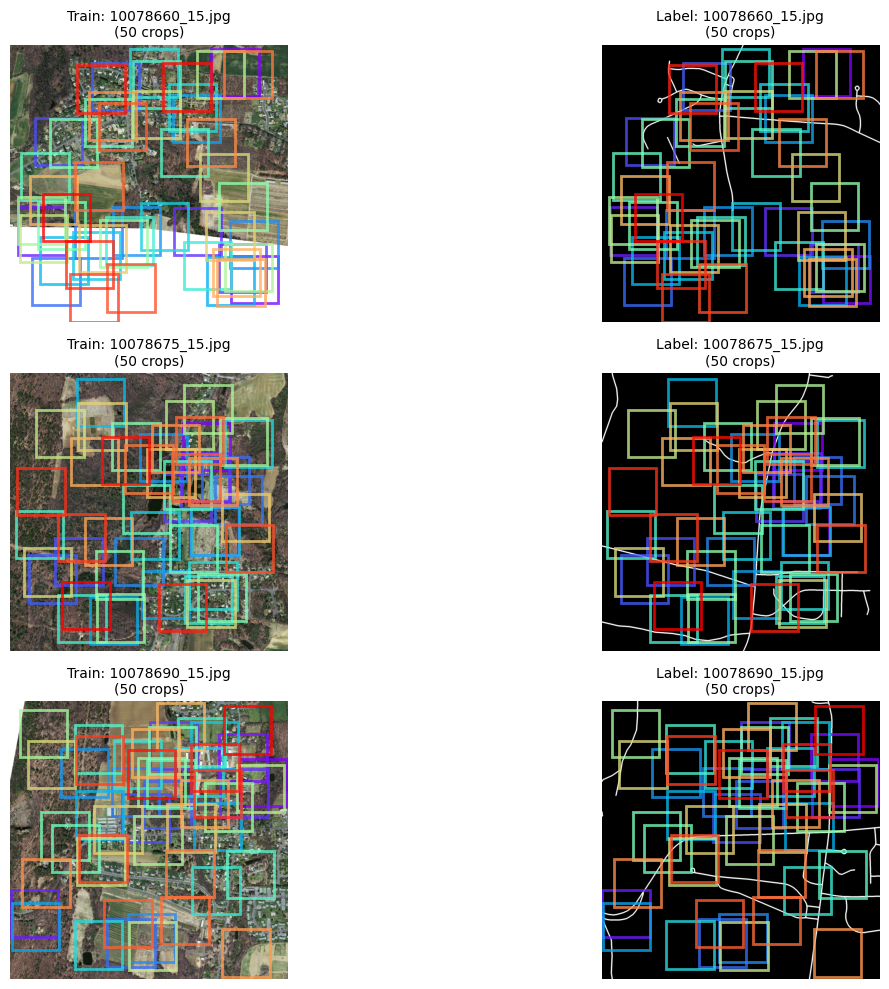

In [22]:
# Get 50 random crops per image
result = get_n_random_crops_per_image(PATH_TO_DATASET, n_crops_per_image=50, num_images=3)

# Visualize where the crops came from
a = visualize_crop_locations(
    PATH_TO_DATASET,
    metadata=result['metadata'],
    max_images=3  # Show first 3 images
)

In [23]:
def calculate_crop_coverage_stats(metadata, patch_size=256, image_size=(1500, 1500)):
    """
    Calculate coverage statistics for crops from metadata.
    
    Computes:
    - Percentage of image area covered by at least one crop
    - Percentage of image area covered more than once (overlaps)
    - Average overlap depth (how many crops cover each covered pixel)
    
    Args:
        metadata: List of metadata dicts (from get_n_random_crops_per_image)
        patch_size: Size of the crop patches
        image_size: Tuple (height, width) of the original images
    
    Returns:
        Dictionary with overall statistics and per-image statistics
    """
    # Group metadata by source file
    crops_by_file = {}
    for item in metadata:
        source = item['source_file']
        if source not in crops_by_file:
            crops_by_file[source] = []
        crops_by_file[source].append(item)
    
    all_stats = []
    
    for filename, crops in crops_by_file.items():
        # Create a coverage map to count how many crops cover each pixel
        h, w = image_size
        coverage_map = np.zeros((h, w), dtype=np.int32)
        
        # Mark all pixels covered by each crop
        for crop_info in crops:
            x, y = crop_info['x'], crop_info['y']
            coverage_map[y:y+patch_size, x:x+patch_size] += 1
        
        # Calculate statistics
        total_pixels = h * w
        covered_pixels = np.sum(coverage_map > 0)
        overlap_pixels = np.sum(coverage_map > 1)
        
        # Percentages
        coverage_pct = 100 * covered_pixels / total_pixels
        overlap_pct = 100 * overlap_pixels / total_pixels
        
        # Additional metrics
        if covered_pixels > 0:
            overlap_ratio = overlap_pixels / covered_pixels  # ratio of overlapped to covered
            avg_overlap_depth = np.sum(coverage_map) / covered_pixels  # avg crops per covered pixel
        else:
            overlap_ratio = 0
            avg_overlap_depth = 0
        
        max_overlap_depth = np.max(coverage_map)
        
        stats = {
            'source_file': filename,
            'num_crops': len(crops),
            'total_area_covered_pct': coverage_pct,
            'overlap_area_pct': overlap_pct,
            'overlap_ratio': overlap_ratio,  # what fraction of covered area is overlapped
            'avg_overlap_depth': avg_overlap_depth,
            'max_overlap_depth': max_overlap_depth,
            'coverage_map': coverage_map
        }
        
        all_stats.append(stats)
    
    # Calculate overall statistics across all images
    overall = {
        'num_images': len(all_stats),
        'total_crops': sum(s['num_crops'] for s in all_stats),
        'avg_coverage_pct': np.mean([s['total_area_covered_pct'] for s in all_stats]),
        'avg_overlap_pct': np.mean([s['overlap_area_pct'] for s in all_stats]),
        'avg_overlap_ratio': np.mean([s['overlap_ratio'] for s in all_stats]),
        'avg_overlap_depth': np.mean([s['avg_overlap_depth'] for s in all_stats]),
        'per_image_stats': all_stats
    }
    
    return overall


def visualize_coverage_map(coverage_stats, image_idx=0, figsize=(12, 5)):
    """
    Visualize the coverage map showing how many times each pixel is covered.
    
    Args:
        coverage_stats: Output from calculate_crop_coverage_stats
        image_idx: Index of the image to visualize (default: 0)
        figsize: Figure size
    """
    stats = coverage_stats['per_image_stats'][image_idx]
    coverage_map = stats['coverage_map']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Coverage heatmap
    im = axes[0].imshow(coverage_map, cmap='hot', interpolation='nearest')
    axes[0].set_title(f"Coverage Heatmap\n{stats['source_file']}")
    axes[0].axis('off')
    plt.colorbar(im, ax=axes[0], label='Number of overlapping crops')
    
    # Binary coverage (covered vs not covered)
    binary_coverage = (coverage_map > 0).astype(float)
    axes[1].imshow(binary_coverage, cmap='gray', interpolation='nearest')
    axes[1].set_title(f"Binary Coverage\n{stats['total_area_covered_pct']:.1f}% covered")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for {stats['source_file']}:")
    print(f"  Number of crops: {stats['num_crops']}")
    print(f"  Total area covered: {stats['total_area_covered_pct']:.2f}%")
    print(f"  Area with overlaps: {stats['overlap_area_pct']:.2f}%")
    print(f"  Overlap ratio: {stats['overlap_ratio']:.2f} ({100*stats['overlap_ratio']:.1f}% of covered area is overlapped)")
    print(f"  Average overlap depth: {stats['avg_overlap_depth']:.2f} crops per covered pixel")
    print(f"  Max overlap depth: {stats['max_overlap_depth']} crops on same pixel")
    
    return fig

Overall Statistics:
  Total images: 3
  Total crops: 150
  Average coverage: 67.97%
  Average overlap area: 41.20%
  Average overlap ratio: 0.61
  Average overlap depth: 2.14


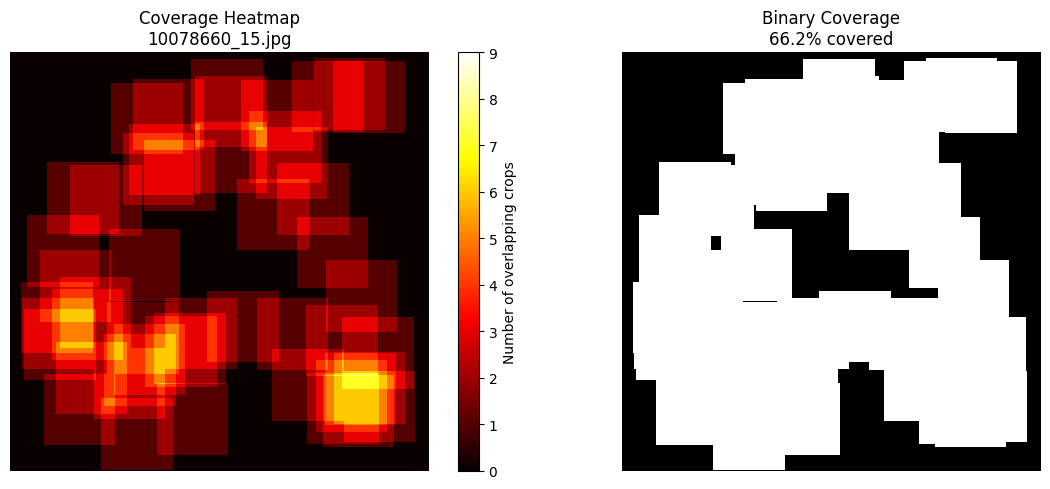


Statistics for 10078660_15.jpg:
  Number of crops: 50
  Total area covered: 66.17%
  Area with overlaps: 41.13%
  Overlap ratio: 0.62 (62.2% of covered area is overlapped)
  Average overlap depth: 2.20 crops per covered pixel
  Max overlap depth: 9 crops on same pixel


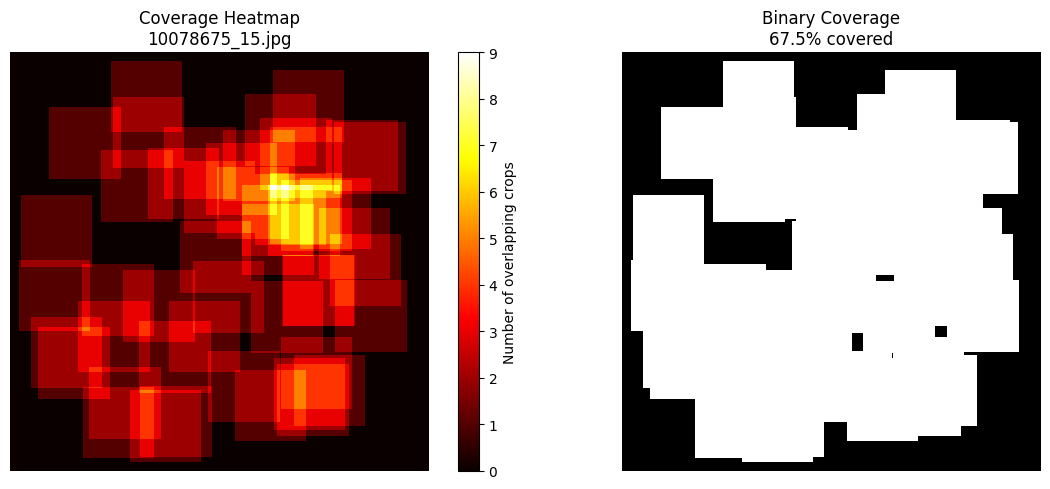


Statistics for 10078675_15.jpg:
  Number of crops: 50
  Total area covered: 67.53%
  Area with overlaps: 41.91%
  Overlap ratio: 0.62 (62.1% of covered area is overlapped)
  Average overlap depth: 2.16 crops per covered pixel
  Max overlap depth: 9 crops on same pixel


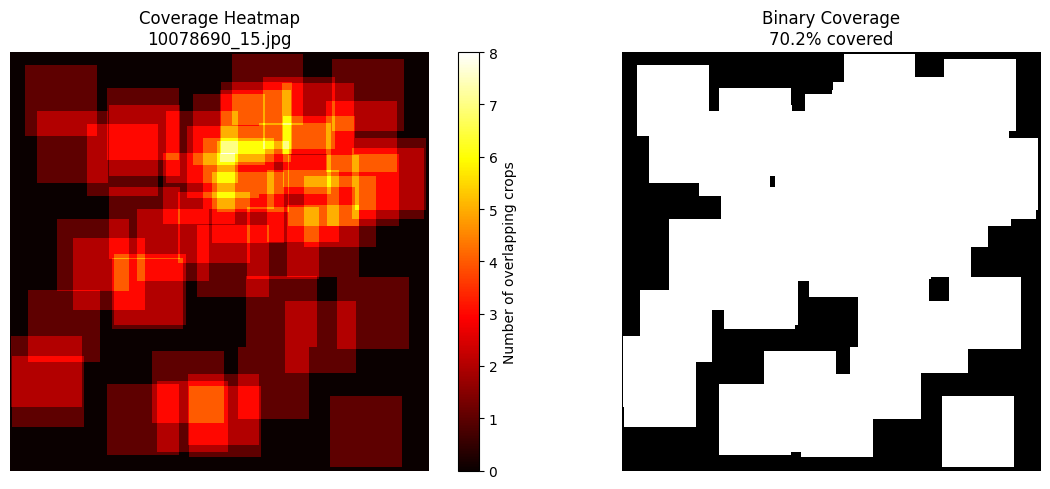


Statistics for 10078690_15.jpg:
  Number of crops: 50
  Total area covered: 70.21%
  Area with overlaps: 40.57%
  Overlap ratio: 0.58 (57.8% of covered area is overlapped)
  Average overlap depth: 2.07 crops per covered pixel
  Max overlap depth: 8 crops on same pixel


In [24]:
# Calculate coverage statistics from the metadata
coverage_stats = calculate_crop_coverage_stats(
    result['metadata'], 
    patch_size=256, 
    image_size=(1500, 1500)
)

# Print overall statistics
print("Overall Statistics:")
print(f"  Total images: {coverage_stats['num_images']}")
print(f"  Total crops: {coverage_stats['total_crops']}")
print(f"  Average coverage: {coverage_stats['avg_coverage_pct']:.2f}%")
print(f"  Average overlap area: {coverage_stats['avg_overlap_pct']:.2f}%")
print(f"  Average overlap ratio: {coverage_stats['avg_overlap_ratio']:.2f}")
print(f"  Average overlap depth: {coverage_stats['avg_overlap_depth']:.2f}")

# Visualize coverage for each image
for i in range(coverage_stats['num_images']):
    visualize_coverage_map(coverage_stats, image_idx=i)

=> We use a grid extract, as well as a random patches for data augmentation

In [25]:
result = get_n_random_crops_per_image(PATH_TO_DATASET, n_crops_per_image=50, num_images=3)

Extracted 50 random crops from 10078660_15.jpg
Extracted 50 random crops from 10078675_15.jpg
Extracted 50 random crops from 10078690_15.jpg


In [34]:
for i, train_crop in enumerate(result['train_crops'][:100]):
    Image.fromarray(train_crop).save(f"{i}.png")

In [ ]:
os.makedirs("../data/processed/patches_256/", exist_ok=True)

crop_dataset(
    PATH_TO_DATASET, 
    train_subdir="train",
    labels_subdir="train_labels",
    patch_size=256,
    overlap=False,
    output_dir="../data/processed/patches_256/"
)

In [ ]:
cropped_dataset = "../data/processed/patches_256/"
train_patches = sorted(list(Path(cropped_dataset + "train/").glob("*.png")))
label_patches = sorted(list(Path(cropped_dataset + "train_labels/").glob("*.png")))
count = 0

os.makedirs("../data/processed/filtered_patches_256/train", exist_ok=True)
os.makedirs("../data/processed/filtered_patches_256/train_labels", exist_ok=True)

In [ ]:
for train, label in zip(train_patches, label_patches):
    train_img = np.array(Image.open(train))
    label_img = np.array(Image.open(label))
    
    if white_pixel_percentage(train_img) < 5.0 and white_pixel_percentage(label_img) > 2.0:
        count += 1
        base_name = train.stem
        Image.fromarray(train_img).save(f"../data/processed/filtered_patches_256/train/{base_name}.png")
        Image.fromarray(label_img).save(f"../data/processed/filtered_patches_256/train_labels/{base_name}.png")
print(f"Kept: {count / len(train_patches) * 100:.2f}% of patches.")